In [1]:
import os
import re
import yaml
import json
import tifffile
import numpy as np
from glob import glob
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))
from src import measures
from src.separator import Separator
from src.cleaner import DoubleStepCleaner

In [2]:
fpath = '/mnt/HD-LSDF/Medaka/201912_beamtime_medaka/'
main_organ = 'brain'

cfg_path = f"/home/ws/er5241/Repos/measuring-repo/measurement_configs/measurement/{main_organ}.yaml"
with open(cfg_path, "r") as stream:
    configs = yaml.safe_load(stream)

cleaning_config = configs['cleaning']
measuring_config = configs['measures']
centering_config = configs.get('centering', [])

In [3]:
def initialize(fname, main_organ):
  img_path = f'{fpath}{fname}/scaled_0.5_8bit_slices.tif'
  msk_path = f'{fpath}{fname}/{main_organ}_scaled_0.5_8bit_slices.tif'
  img = tifffile.imread(img_path)
  msk = tifffile.imread(msk_path)

  cleaner = DoubleStepCleaner(**cleaning_config)
  msk_clean, roi = cleaner(msk)
  img_clean = img[roi]

  centers = {}
  for centering in centering_config:
      centers[centering['name']] = Separator((msk_clean == centering['label_id']), centering['function'], centering['count'])

  return img_clean, msk_clean, centers


def get_random_ids(n=1):
  fls = glob(f'{fpath}/Medaka_*_*')
  fls = np.random.choice(fls,n, replace=False)
  ids = [os.path.basename(fl) for fl in fls]
  return ids

In [5]:
fname = get_random_ids()[0]

fname = 'Medaka_1129_25-1'
print(fname)

img_clean, msk_clean, centers = initialize(fname, main_organ)

Medaka_1129_25-1


### test structuring elements and dilation

In [5]:
lbl = measuring_config[5]
print(lbl['id'], lbl['name'])
lbl_mask = (msk_clean == lbl['id'])

6 cerebellum


In [58]:
def organ_metric(markup, volume, metric):

    if metric == 'volume':
        measurement = markup.sum()
    elif metric == 'surface_area':
        measurement = find_boundaries(markup).sum()
    elif metric == 'mean':
        measurement = volume[markup].mean()
    elif metric == 'median':
        measurement = np.median(volume[markup])
    elif metric == 'std':
        measurement = volume[markup].std()
    elif metric == 'perc_1':
        measurement = np.percentile(volume[markup], 1)
    elif metric == 'perc_99':
        measurement = np.percentile(volume[markup], 99)

    return measurement

In [47]:
from skimage.morphology import ball
from scipy.ndimage import binary_fill_holes, binary_dilation, binary_erosion, generate_binary_structure

diamond = generate_binary_structure(rank=3, connectivity=1)

(21, 21, 21)
(3, 3, 3)


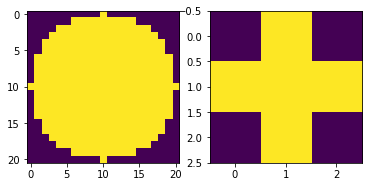

In [92]:
fig, axs = plt.subplots(1,2)

print(ball(10).shape)
axs[0].imshow(ball(10)[10])
print(diamond.shape)
axs[1].imshow(diamond[1])

plt.show()

In [78]:
%timeit -n 1 -r 1 binary_dilation(lbl_mask, ball(radius=10, dtype=bool))

38.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [77]:
%timeit binary_dilation(lbl_mask, diamond, iterations=10)

180 ms ± 9.35 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### visual comparison

In [113]:
 def plot_slice(img, msk, plt):
    ne_slc = np.where(msk.sum((1, 2))>0)[0]
    slice_id = ne_slc[len(ne_slc)//2]
    slice_id = np.argmax(msk.sum((1, 2)))

    plt.imshow(img[slice_id], cmap='gray')
    plt.imshow(msk[slice_id], cmap='tab10', alpha=(msk[slice_id]>0)*0.7)

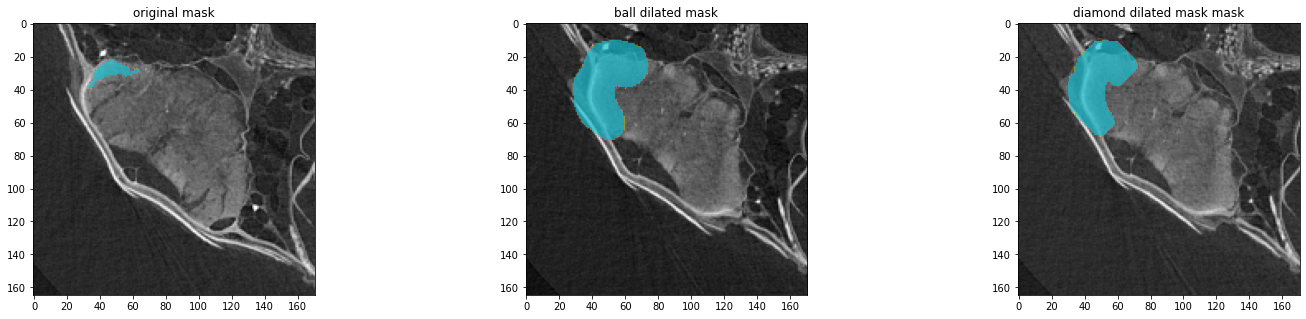

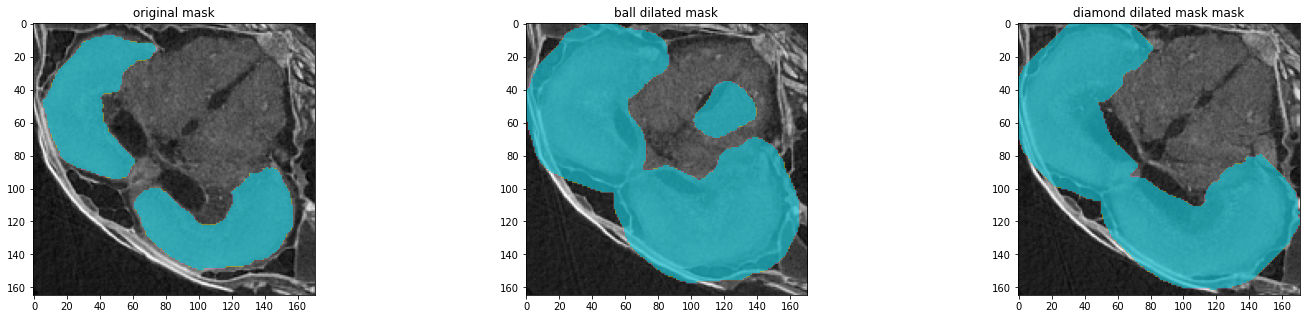

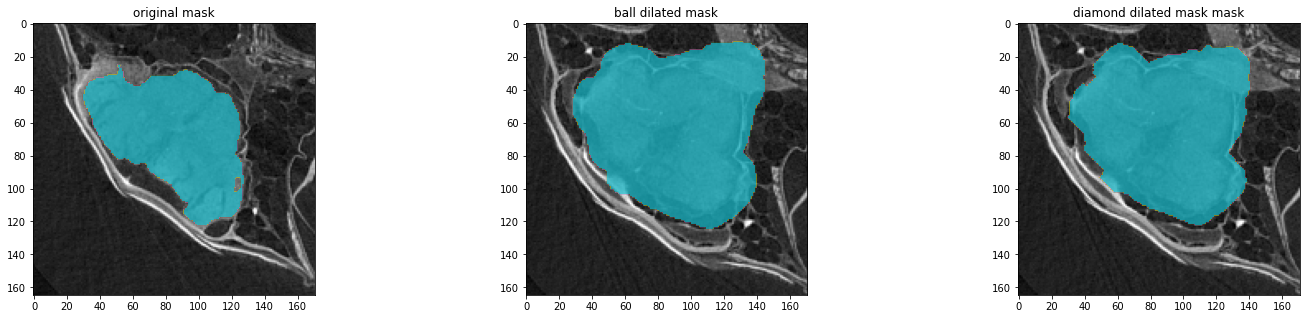

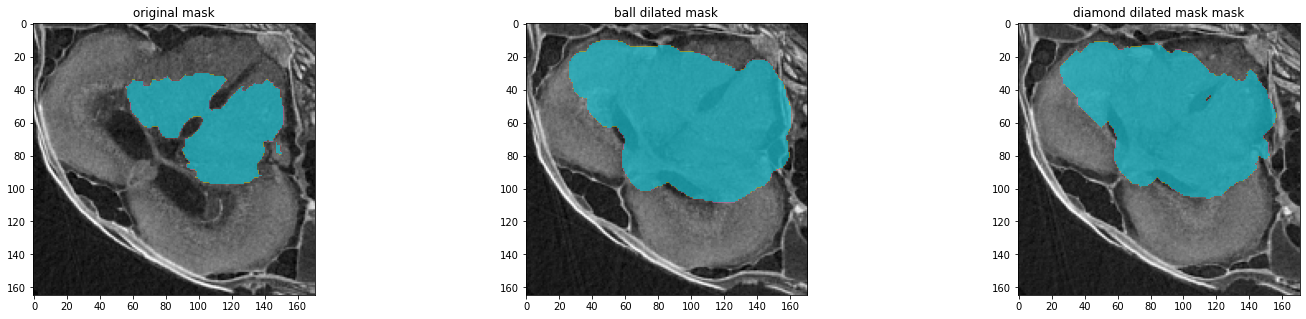

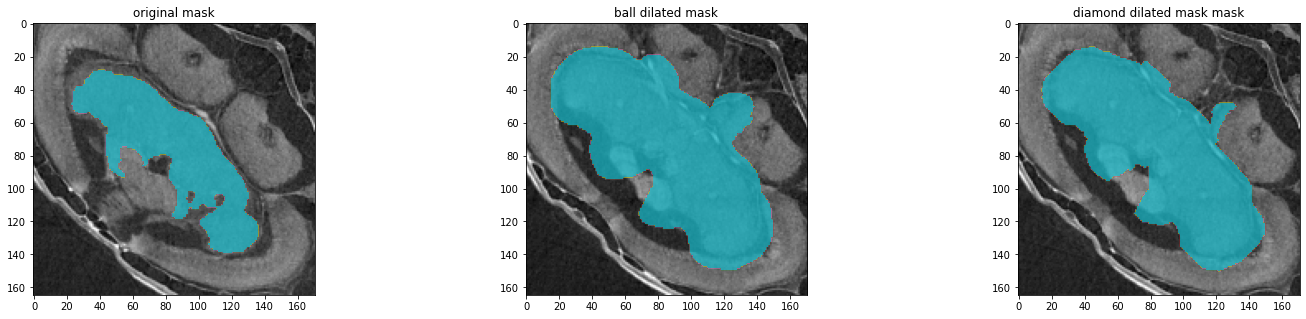

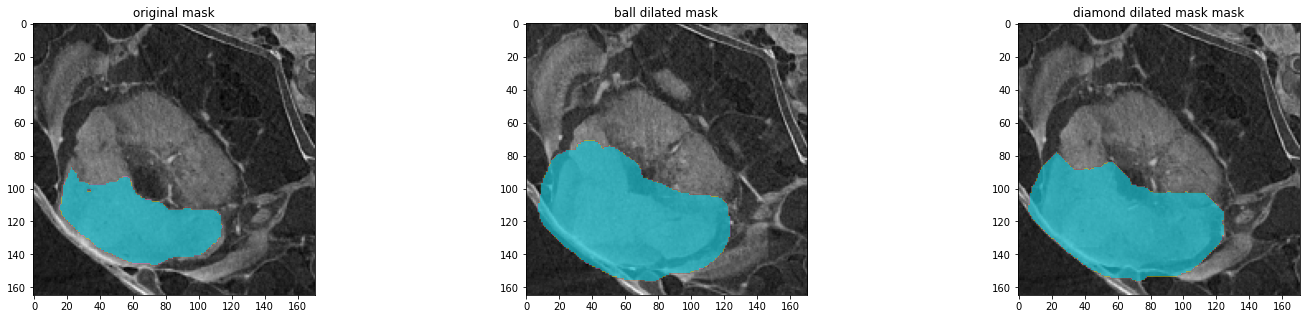

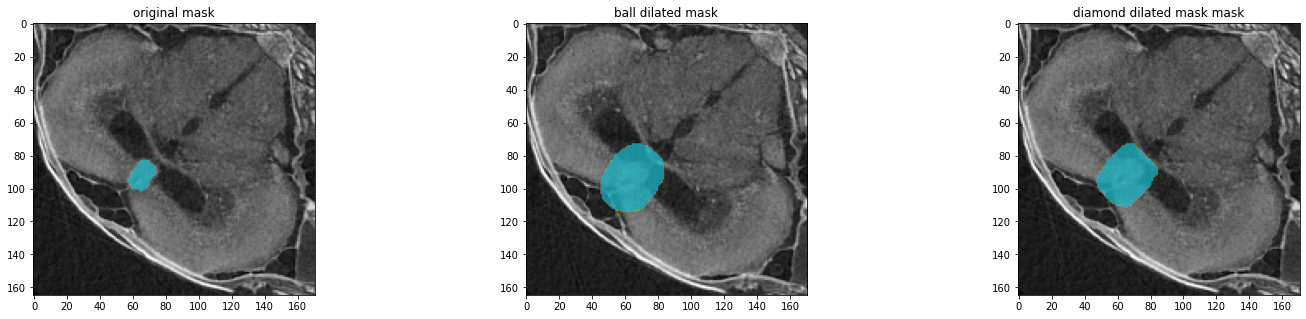

In [117]:
id = get_random_ids()[0]

#img_clean, msk_clean, centers = initialize(id, main_organ)

for lbl in measuring_config:
  lbl_mask = (msk_clean == lbl['id'])
  # skip if empty slice
  if not any(img_clean[lbl_mask]): continue
  
  fig, axs = plt.subplots(1,3, figsize=(25,5))
  
  plt.axes(axs[0])
  plot_slice(img_clean, lbl_mask, plt)
  plt.title('original mask')
  
  plt.axes(axs[1])
  dilated_mask = binary_dilation(lbl_mask, ball(radius=10, dtype=bool))
  plot_slice(img_clean, dilated_mask, plt)
  plt.title('ball dilated mask')
  
  plt.axes(axs[2])
  dilated_mask = binary_dilation(lbl_mask, diamond, iterations=10)
  plot_slice(img_clean, dilated_mask, plt)
  plt.title('diamond dilated mask mask')
  
  plt.show()

#### comparing ball vs diamond for result of dilation.mean()

In [59]:
means, ball_means, diamond_means = [], [], []
ids = get_random_ids(10)

for id in tqdm(ids):
  print(id)
  try:
    img_clean, msk_clean, centers = initialize(id, main_organ)
    lbl = measuring_config[5]  # cerebellum
    lbl_mask = (msk_clean == lbl['id'])
    if not any(img_clean[lbl_mask]): raise Exception('empty slice')
      
    # original
    measurement = organ_metric(lbl_mask, img_clean, 'mean')
    means.append(measurement)
    print(measurement)
    
    # dilation with ball
    dilated_mask = binary_dilation(lbl_mask, ball(radius=10, dtype=bool))
    measurement = organ_metric(dilated_mask, img_clean, 'mean')
    ball_means.append(measurement)
    print(measurement)

    # dilation with diamond
    dilated_mask = binary_dilation(lbl_mask, diamond, iterations=10)
    measurement = organ_metric(dilated_mask, img_clean, 'mean')
    diamond_means.append(measurement)
    print(measurement)
  except Exception as e:
    print(str(e))
  print()

  0%|          | 0/30 [00:00<?, ?it/s]

Medaka_1092_14-2
('bounding box cleaner', 'bounding box is too small')

Medaka_1098_14-2
128.23163806158504
108.39110520925941
111.54427892147432

Medaka_1383_134-1
118.45124177419211
107.31964019853525
109.19974525810431

Medaka_1179_55-2
('bounding box cleaner', 'bounding box is too small')

Medaka_1386_134-1
131.21442088246482
113.64891445169047
115.69386607544503

Medaka_1222_75-1
120.76042374426197
105.65605799950848
107.3195434172095

Medaka_1342_110-2
150.82498106973222
128.07930425818498
130.516097693898

Medaka_1336_110-2
('bounding box cleaner', 'bounding box is too small')

Medaka_1317_106-1
('bounding box cleaner', 'bounding box is too small')

Medaka_1126_23-2
127.97378063479309
100.62460459971557
102.90208233654386

Medaka_1064_4-1
116.5028610091984
95.54693851231066
98.10034469037018

Medaka_1170_53-2
122.75865338407388
105.78599511659769
108.25077811866345

Medaka_1141_33-1
121.62258565070032
104.55343157688253
107.34675923503178

Medaka_1413_139-4
143.8047391805167
123

22


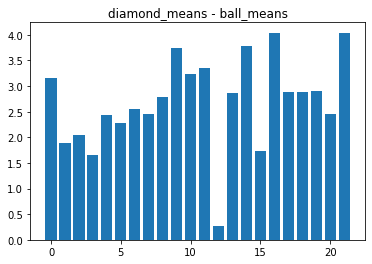

In [60]:
means, ball_means, diamond_means = np.array(means), np.array(ball_means), np.array(diamond_means)
print(len(ball_means))

plt.bar(range(len(ball_means)),diamond_means-ball_means)
plt.title('diamond_means - ball_means')
plt.show()

####  comparing with already calculated measurements from db

In [12]:
db_path = "/home/ws/er5241/Repos/measuring-repo/artifacts/debug_uncroppedb.json"

a_file = open(db_path, "r")
debug = json.load(a_file)['_default']
a_file.close()

In [69]:
measure_types = ['color_mean_dilated', 'color_std_dilated']
ball_measures = {measure_type : [] for measure_type in measure_types}
diamond_measures = {measure_type : [] for measure_type in measure_types}

In [ ]:
for fish in tqdm(debug.values()):
  try:
    id = fish['id']
    line = fish.get('line')
    fname = f'Medaka_{id}_{line}'

    img_clean, msk_clean, centers = initialize(fname, main_organ=main_organ)

    for lbl in measuring_config:
      sub_organ = lbl['name']
      lbl_mask = (msk_clean == lbl['id'])
      # skip if empty slice
      if not any(img_clean[lbl_mask]): continue

      for meas_type in measure_types:
        ball_meas = fish[main_organ][sub_organ][meas_type]


        dilated_mask = binary_dilation(lbl_mask, diamond, iterations=10)
        # get the base function as we have already applied dilation
        base_meas = meas_type.rpartition('_')[0]
        mf = getattr(measures, base_meas)
        cc = centers[lbl['center']] if ('center' in lbl.keys()) else None
        diamond_meas = mf(lbl_mask, img_clean, cc)

        ball_measures[meas_type].extend(ball_meas)
        diamond_measures[meas_type].extend(diamond_meas)
        #print(meas_type,ball_meas,diamond_meas)
  except Exception as e:
    print(str(e))

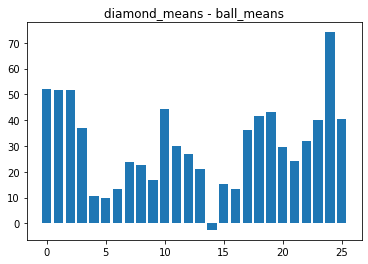

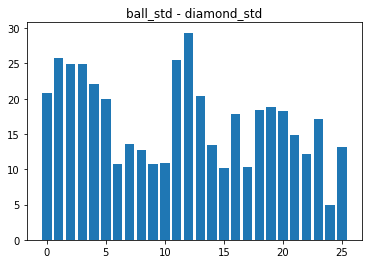

In [121]:
x = np.array(ball_measures['color_mean_dilated'])
y = np.array(diamond_measures['color_mean_dilated'])
plt.bar(range(len(x)),y-x)
plt.title('diamond_means - ball_means')
plt.show()

x = np.array(ball_measures['color_std_dilated'])
y = np.array(diamond_measures['color_std_dilated'])
plt.bar(range(len(x)),x-y)
plt.title('ball_std - diamond_std')
plt.show()